<a href="https://colab.research.google.com/github/ayyucedemirbas/sensor_fusion/blob/main/KalmanFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

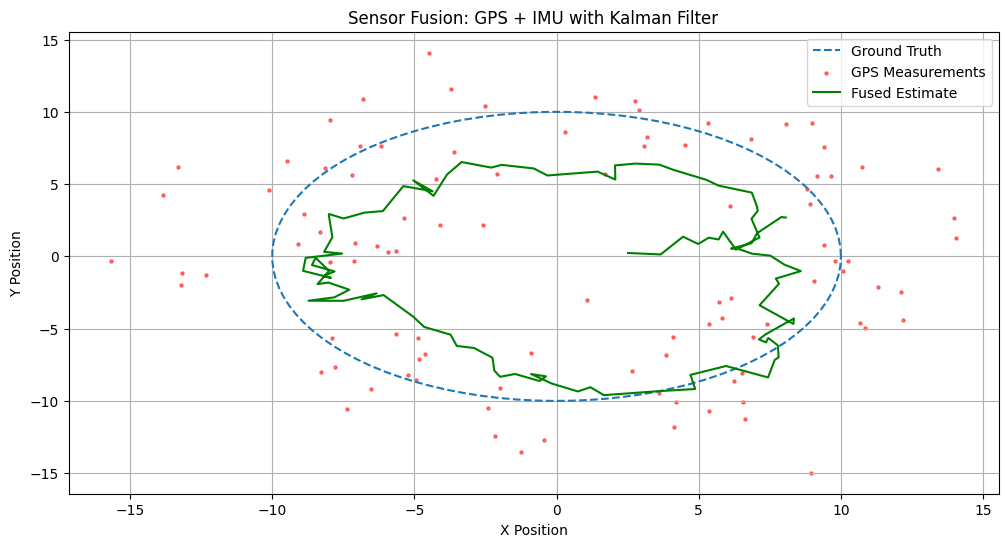

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class KalmanFilter:
    def __init__(self, dt, state_dim, measurement_dim):
        self.dt = dt
        self.state = np.zeros(state_dim)
        self.F = np.array([
            [1, 0, dt, 0],
            [0, 1, 0, dt],
            [0, 0, 1, 0],
            [0, 0, 0, 1]
        ])

        self.H = np.array([
            [1, 0, 0, 0],
            [0, 1, 0, 0]
        ])

        self.Q = np.eye(4) * 0.1

        self.R = np.eye(2) * 5

        self.P = np.eye(4)

    def predict(self, acceleration):
        B = np.array([
            [0.5 * self.dt**2, 0],
            [0, 0.5 * self.dt**2],
            [self.dt, 0],
            [0, self.dt]
        ])
        self.state = self.F @ self.state + B @ acceleration
        self.P = self.F @ self.P @ self.F.T + self.Q
        return self.state

    def update(self, measurement):
        K = self.P @ self.H.T @ np.linalg.inv(self.H @ self.P @ self.H.T + self.R)
        self.state = self.state + K @ (measurement - self.H @ self.state)
        self.P = (np.eye(4) - K @ self.H) @ self.P
        return self.state

dt = 0.1
total_time = 10
steps = int(total_time / dt)

t = np.linspace(0, 2*np.pi, steps)
true_x = 10 * np.cos(t)
true_y = 10 * np.sin(t)

true_vx = -10 * np.sin(t)
true_vy = 10 * np.cos(t)
acceleration = np.vstack([-10 * np.cos(t), -10 * np.sin(t)]).T  # a = dv/dt

# Simulate noisy GPS measurements
gps_noise = np.random.normal(0, 3, (steps, 2))  # Add Gaussian noise
gps_x = true_x + gps_noise[:, 0]
gps_y = true_y + gps_noise[:, 1]


kf = KalmanFilter(dt, state_dim=4, measurement_dim=2)
estimated_states = []

for i in range(steps):
    # Predict step (using IMU acceleration)
    kf.predict(acceleration[i])

    # Update step (using GPS measurement)
    fused_state = kf.update(np.array([gps_x[i], gps_y[i]]))
    estimated_states.append(fused_state[:2])  # Store position

estimated_states = np.array(estimated_states)

plt.figure(figsize=(12, 6))
plt.plot(true_x, true_y, label='Ground Truth', linestyle='--')
plt.scatter(gps_x, gps_y, s=5, label='GPS Measurements', color='red', alpha=0.5)
plt.plot(estimated_states[:, 0], estimated_states[:, 1], label='Fused Estimate', color='green')
plt.legend()
plt.title('Sensor Fusion: GPS + IMU with Kalman Filter')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.show()